# 📚 Agentic RAG System
This project implements an **intelligent research assistant** that retrieves and synthesizes information using:
1. **ArXiv papers** as the primary knowledge source (**RAG approach**)
2. **Web search (Tavily API)**
3. **LangGraph** for orchestrating the decision-making workflow

## 🎯 Purpose

The system is designed to provide research-backed answers to technical and scientific questions by:
- Prioritizing academic and research papers from ArXiv for scientific queries
- Falling back to web search for recent developments or non-academic topics
- Maintaining conversation context for coherent multi-turn interactions
- Ensuring proper attribution and citations in responses

## 🔑 Prerequisites

To use this system, you'll need:

1. **OpenAI API Key**
   - Required for:
     - Text embeddings (for semantic search)
     - Response generation (GPT-4 Turbo)
     - Routing decisions (GPT-4o-mini)
   - Get it from: [OpenAI Platform](https://platform.openai.com)

2. **Tavily API Key**
   - Required for:
     - Web search fallback functionality
     - Real-time information retrieval
     - Academic domain filtering
   - Get it from: [Tavily](https://app.tavily.com)

3. **Python Environment**
   - Python 3.8 or higher
   - Required packages (will be installed automatically):
     - langchain-community
     - langchain_chroma
     - langchain_core
     - langchain_openai
     - langchain_text_splitters
     - langgraph
     - tavily-python
     - openai
     - python-dotenv


## 🤖 Agentic Workflow Architecture

The user workflow is translated into an agentic system through the following components:

1. **State Management**
   - **Conversation State**: Tracks user queries, system responses, and context
   - **Search State**: Maintains information about current search results and sources
   - **Decision State**: Stores routing decisions and their rationale

2. **Agent Components**
   - **Router Agent**: Makes decisions about information sources
     - Analyzes query type and context
     - Determines optimal search strategy
     - Handles fallback mechanisms
   
   - **Search Agent**: Executes information retrieval
     - Manages ArXiv API interactions
     - Handles Tavily web search
     - Processes and filters results
   
   - **Synthesis Agent**: Combines and formats information
     - Merges multiple sources
     - Ensures proper attribution
     - Generates coherent responses

3. **Feedback Loop**
   - System learns from user interactions
   - Improves routing decisions over time
   - Adapts to user preferences and query patterns

## 📊 Data Requirements and Sources

The system requires and manages several types of data:

1. **Input Data**
   - **User Queries**: Natural language questions and follow-ups
   - **Conversation History**: Previous interactions for context
   - **User Preferences**: Optional settings for search behavior

2. **Knowledge Sources**
   - **ArXiv Papers**:
     - Source: ArXiv API
     - Format: PDF documents
     - Update Frequency: Daily
     - Coverage: Scientific and technical papers
   
   - **Web Content**:
     - Source: Tavily API
     - Format: Web pages and documents
     - Update Frequency: Real-time
     - Coverage: News, blogs, documentation, etc.

3. **Processed Data**
   - **Embeddings**: Vector representations of text
     - Generated using OpenAI's embedding model
     - Stored in vector database
   
   - **Chunks**: Processed text segments
     - Size: Optimized for semantic search
     - Metadata: Source, date, relevance score
   
   - **Citations**: Reference information
     - Paper titles, authors, URLs
     - Web page sources and dates

4. **Output Data**
   - **Responses**: Generated answers with citations
   - **Search Results**: Ranked and filtered information
   - **Conversation Logs**: Interaction history


[link text](https://)

In [2]:
%%capture
# Install required packages
! pip install -qU langchain langgraph pypdf chromadb tavily-python openai python-dotenv pyboxen langchain-community langchain_chroma langchain_core langchain_openai langchain_text_splitters

In [3]:
# Import required libraries
import os  # Provides functions to interact with the operating system.
from pyboxen import boxen  # Used to display stylized boxes in the terminal for better CLI UI.
from getpass import getpass  # Allows secure password input without echoing.

from typing import TypedDict, List, Dict, Optional, Literal, Union, Annotated, cast  # Used for type annotations and static type checking.
from langchain_core.documents import Document  # Represents and structures text data in LangChain.
from langchain_core.output_parsers import StrOutputParser  # Parses raw LLM output into usable string format.
from langchain_community.document_loaders import PyPDFLoader  # Loads and extracts text from PDF documents.

from langchain_text_splitters import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter  # Splits text into chunks using markdown headers or character limits.

from langchain_chroma import Chroma  # Provides integration with Chroma vector store for embedding storage and retrieval.
from langchain_openai import OpenAIEmbeddings, ChatOpenAI  # Interfaces with OpenAI for embeddings and chat models.

from langchain_core.prompts import ChatPromptTemplate  # Manages prompt templates for chat-based interactions.

from langgraph.graph import StateGraph, END  # Helps define state-based logic flows for chat systems.
from langchain.memory import ConversationBufferMemory  # Maintains memory of past conversation for context retention.

from tavily import TavilyClient  # Interfaces with Tavily for real-time web search.

# API Key Submission

Please follow the instructions below:

1. **Provide the Tavily API Key**
2. **Provide the Open API Key**
3. **Press Enter** to proceed


In [4]:
# Set API keys
os.environ["TAVILY_API_KEY"] = getpass("Enter Tavily API Key (get from https://app.tavily.com): ")
os.environ["OPENAI_API_KEY"] = getpass("Enter OpenAI API Key: ")

## 2. Define State and System Architecture

This is important because Agents need context to take decisions and showcase "Agency", the state helps us define the information that the agent will require and also capture information through out the whole process.

We'll define our system's state and flow using **LangGraph**. The state will track our:
- **Input question**
- **Retrieved ArXiv results**
- **Web search results**
- **Final answer**
- **Conversation history for context**


In [5]:
# Define our system state - this is what passes between nodes in our graph
class AgentState(TypedDict):
    """State definition for our agentic RAG system"""
    question: str  # User's current question
    routing_decision: Literal["arxiv", "web", "both"] # Explicit decision from router
    arxiv_results: Optional[List[Document]]  # Results from ArXiv papers (if any)
    web_results: Optional[List[Dict]]  # Results from web search (if any)
    direct_answer: Optional[str] # Direct answer from Tavily (if any)
    answer: str  # Final synthesized answer
    conversation_history: str  # Previous Q&A for context
    memory: any
    next_node: Optional[Literal["web_search", "synthesize"]] # Helper key for conditional routing AFTER arxiv retrieval when "both" is chosen

## 3. Router Node Implementation

The **Router Node** is responsible for deciding whether to use **ArXiv papers** or **web search**.
- **First**, it tries to use **ArXiv papers** (our local knowledge source).
- **Falls back** to **web search** if needed.

This demonstrates **strategic decision-making capabilities**.


In [6]:
router_prompt = ChatPromptTemplate.from_template("""
You are a highly specialized research assistant with access to two information sources:
1. A collection of ArXiv research papers
2. A web search tool

Your task is to determine which source(s) would be better to answer the user's question.
FIRST try to use ArXiv papers for scientific and academic questions.
ONLY use web search if:
- The question requires very recent information not likely in research papers
- The question is about general knowledge, news, or non-academic topics
- The question asks for information beyond what academic papers would contain
Choose BOTH if the question requires integrating academic concepts with recent developments, practical applications, or comparing academic views with general information

Consider the conversation history for context.

Question: {question}
Conversation History: {conversation_history}

Respond with ONLY ONE of these two options:
"arxiv" - if the question should be answered using research papers
"web" - if the question requires web search
"both" - if both ArXiv and web search are needed

Your decision should be a single word only (either "arxiv", "web" or "both"). Do not include any explanation, reasoning, or additional text in your response.
""")

def router_node(state: AgentState) -> dict:
    """
    Determines whether to use ArXiv papers, web search or both based on the question.

    Args:
        state: Current state containing the question and conversation history

    Returns:
        Dict containing the routing decision.
    """
    # Use a lighter model for routing decisions
    llm = ChatOpenAI(model="gpt-4o-mini")

    # Create a chain that outputs just the decision text
    chain = router_prompt | llm | StrOutputParser()

    # Invoke the chain with our question and history
    # Get the content of the AIMessage object instead of directly calling strip()
    decision = chain.invoke({
        "question": state["question"],
        "conversation_history": state["conversation_history"]
    }).strip().lower()

    # Validate decision and set default if needed
    if decision not in ["arxiv", "web", "both"]:
        print(f"Router Warning: Unexpected decision '{decision}'. Defaulting to 'web'.")
        decision = "web"
    
    print(boxen(f"Router raw decision: {decision}", title=">>> Router Node", color="blue", padding=(1, 2)))
    
    return {"routing_decision": decision}

# ArXiv Processor Documentation

## Overview
The `ArXivProcessor` class is designed to handle processing ArXiv PDFs for retrieval-augmented generation (RAG) systems. It implements document-aware chunking strategies specifically optimized for scientific papers.

## Key Features
- **Two-step chunking strategy**:
 1. Markdown header splitting to preserve document structure
 2. Recursive character splitting for handling longer sections effectively
- **Confidence-based retrieval** with threshold filtering
- **Metadata preservation** from original PDFs

## Class Structure

### Constructor: `__init__()`
Initializes the processor with specialized document chunking strategies:
- `MarkdownHeaderTextSplitter` to maintain document section structure
- `RecursiveCharacterTextSplitter` for detailed content subdivision

### Methods

#### `load_and_process(pdf_urls: List[str])`
Processes ArXiv PDFs with document-aware chunking:
- Loads PDFs from provided URLs
- Converts content to markdown-style text with headers
- Applies two-stage chunking process
- Creates a vector store with OpenAI embeddings

#### `retrieve(question: str, confidence_threshold: float = 0.75, k: int = 5)`
Retrieves relevant chunks with confidence scoring:
- Performs similarity search based on user query
- Filters results by confidence threshold
- Returns only high-relevance document chunks

## Implementation Example
The documented code includes a sample implementation that loads and processes two ArXiv papers:
- Quantum computing paper: https://arxiv.org/pdf/2305.10343.pdf
- LLM research paper: https://arxiv.org/pdf/2303.04137.pdf

## Dependencies
- `PyPDFLoader` for PDF handling
- `MarkdownHeaderTextSplitter` and `RecursiveCharacterTextSplitter` for content chunking
- `OpenAIEmbeddings` for vector embeddings
- `Chroma` for vector storage

In [18]:
class ArXivProcessor:
    """
    Handles processing ArXiv PDFs for retrieval-augmented generation.
    """
    def __init__(self):
        """
        Initialize the processor with document-aware chunking strategies.

        The chunking strategy uses a two-step approach:
        1. Markdown header splitting preserves document structure and headers
        2. Recursive character splitting handles longer sections effectively
        """
        # Header splitter preserves section structure in scientific papers
        self.header_splitter = MarkdownHeaderTextSplitter(
            headers_to_split_on=[
                ("#", "Section"),           # Main sections
                ("##", "Subsection"),       # Subsections
                ("###", "Subsubsection")    # Sub-subsections
            ]
        )

        # Recursive splitter handles nested hierarchies and technical content
        # - Chunk size of 1000 balances context vs specificity
        # - Overlap of 200 ensures continuity between chunks
        # - Separators prioritize natural breaks in scientific text
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=1000,
            chunk_overlap=200,
            separators=["\n\n", "\n", "(?<=\. )", " ", ""]
        )

        # Will be initialized when documents are loaded
        self.vector_store = None

    def load_and_process(self, pdf_urls: List[str]):
        """
        Process ArXiv PDFs with document-aware chunking

        Args:
            pdf_urls: List of URLs to ArXiv PDFs
        """
        all_chunks = []

        # Process each PDF
        for url in pdf_urls:
            print(boxen(f"Loading PDF from {url}", title=">>> PDF Loading", color="blue", padding=1))
            loader = PyPDFLoader(url)
            pages = loader.load()

            # Process each page
            for page in pages:
                # Convert PDF content to markdown-style text with headers
                page_text = f"# {page.metadata['source']}\n## Page {page.metadata['page']}\n{page.page_content}"

                # First split by headers to maintain document structure
                header_chunks = self.header_splitter.split_text(page_text)

                # Then split large sections into smaller chunks
                small_chunks = self.text_splitter.split_documents(header_chunks)

                # Add to our collection
                all_chunks.extend(small_chunks)

        print(boxen(f"Created {len(all_chunks)} chunks from {len(pdf_urls)} PDFs", title=">>> Processing Complete", color="green", padding=1))

        # Create vector store with OpenAI embeddings
        self.vector_store = Chroma.from_documents(
            documents=all_chunks,
            embedding=OpenAIEmbeddings(),
            persist_directory="./arxiv_db"
        )

    def retrieve(self, question: str, confidence_threshold: float = 0.75, k: int = 5):
        """
        Retrieve relevant chunks with confidence scoring

        Args:
            question: User question to find relevant information for
            confidence_threshold: Minimum relevance score (0-1) to include a result
            k: Maximum number of results to return

        Returns:
            List of relevant document chunks that meet the threshold
        """
        if not self.vector_store:
            raise ValueError("No ArXiv documents loaded. Run load_and_process first.")

        # Perform similarity search with relevance scores
        results = self.vector_store.similarity_search_with_relevance_scores(
            question, k=k
        )

        # Filter by confidence threshold
        filtered_results = [doc for doc, score in results if score >= confidence_threshold]

        print(boxen(f"Found {len(filtered_results)} relevant chunks above threshold {confidence_threshold}", title=">>> ArXivProcessor", color="yellow", padding=1))

        return filtered_results

# Load sample ArXiv PDFs
print(boxen("Initializing ArXiv processor with sample papers...", title=">>> Initialization", color="cyan", padding=1))
arxiv_processor = ArXivProcessor()
arxiv_processor.load_and_process([
    "https://arxiv.org/pdf/2504.10412"   # LLM research paper
])
print(boxen("ArXiv processor initialized!", title=">>> Status", color="green", padding=1))

╭─ >>> Initialization ───────────────────────────────────╮                                                         
│                                                        │                                                         
│   Initializing ArXiv processor with sample papers...   │                                                         
│                                                        │                                                         
╰────────────────────────────────────────────────────────╯                                                         



╭─ >>> PDF Loading ─────────────────────────────────────╮                                                          
│                                                       │                                                          
│   Loading PDF from https://arxiv.org/pdf/2504.10412   │                                                          
│                                                       │                                                          
╰───────────────────────────────────────────────────────╯                                                          



╭─ >>> Processing Complete ─────────╮                                                                              
│                                   │                                                                              
│   Created 35 chunks from 1 PDFs   │                                                                              
│                                   │                                                                              
╰───────────────────────────────────╯                                                                              



╭─ >>> Status ─────────────────────╮                                                                               
│                                  │                                                                               
│   ArXiv processor initialized!   │                                                                               
│                                  │                                                                               
╰──────────────────────────────────╯                                                                               



# ArXiv Retrieval Node Documentation

## Overview
The `arxiv_retrieval_node` function serves as a retrieval component in an agent-based system, fetching relevant scientific information from ArXiv papers based on user queries.

## Function Signature
`arxiv_retrieval_node(state: AgentState) -> dict`

## Parameters
- `state`: An AgentState object containing the current conversation state, including:
 - `question`: The user's query to search for in ArXiv papers

## Functionality
The function:
1. Extracts the user's question from the input state
2. Calls the `arxiv_processor.retrieve()` method to find relevant document chunks
3. Uses a reduced confidence threshold (0.5) compared to the default (0.75) to improve recall
4. Returns the retrieved documents for further processing

## Return Value
Returns a dictionary with:
- `arxiv_results`: A list of document chunks from ArXiv papers relevant to the user's question

## Integration Notes
- This function is designed to be used as a node in an agent workflow
- The reduced confidence threshold ensures more potential matches are returned, prioritizing recall over precision
- The retrieved documents can be used by subsequent nodes for answering the user's question

In [8]:
# Ensure arxiv_processor is accessible (defined in previous cells)
assert 'arxiv_processor' in globals(), "arxiv_processor must be initialized first"

def arxiv_retrieval_node(state: AgentState) -> dict:
    """
    Retrieves relevant information from ArXiv papers based on the question.
    Determines the next node based on the initial routing decision.
    
    Args:
        state: Current state containing the question and routing decision

    Returns:
        Updated state with arxiv_results and the next node destination.
    """      
    question = state["question"]
    routing_decision = state["routing_decision"]
    relevant_docs = []
    next_dest = "synthesize" # Default next step
    
    # Retrieve relevant documents from ArXiv
    try:
        relevant_docs = arxiv_processor.retrieve(
            question=question,
            confidence_threshold=0.5  # Adjusted threshold for better recall
        )
        print(boxen(f"Found {len(relevant_docs)} relevant ArXiv chunks.", title=">>> ArXiv Retrieval Node", color="blue", padding=(1, 2)))
    except Exception as e:
        print(boxen(f"Error during ArXiv retrieval: {e}", title=">>> ArXiv Retrieval Node", color="red", padding=(1, 2)))
        # Continue even if ArXiv fails, maybe web search will work if "both" was chosen

    # TODO: Check if we found enough relevant content
    
    info_message = ""
    # Decide the next step
    if routing_decision == "both":
        info_message = "Routing decision was 'both', proceeding to Web Search next."
        print(boxen(info_message, title=">>> Routing", color="green", padding=(1, 2)))
        next_dest = "web_search"
    else: # routing_decision was "arxiv"
        info_message = "Routing decision was 'arxiv', proceeding to Synthesize next."
        print(boxen(info_message, title=">>> Routing", color="green", padding=(1, 2)))
        next_dest = "synthesize"
    
    return {"arxiv_results": relevant_docs, "next_node": next_dest}

## 5. Web Search Node Implementation

The **Web Search Node** uses the **Tavily API** to search the web when **ArXiv papers** don't have the answer.

- **Optimizes** the search query
- **Filters and processes** results
- **Ensures** proper attribution


In [9]:
web_searcher = TavilyClient()

def web_search_node(state: AgentState) -> dict:
    """
    Searches the web for information using the Tavily API.
    
    Args:
        state: current state containing the question

    Returns:
        Updated state with web_results and direct_answer.
    """    
    web_res = None
    direct_ans = None
    
    try:
        # Include academic domains to improve search quality
        academic_domains = ["arxiv.org", "scholar.google.com", "researchgate.net", "edu"]

        # Get search results with answer
        search_response = web_searcher.search(
            query=state["question"],
            max_results=5,
            include_domains=academic_domains,
            search_depth="advanced",  # Use advanced search for better results
            include_answer=True  # Request direct answer
        )
        web_res = search_response.get("results", [])
        direct_ans = search_response.get("answer")
        info_message = f"Found {len(web_res)} web results." + (f" Direct answer found." if direct_ans else "")
        print(boxen(info_message, title=">>> Web Search Node", color="blue", padding=(1, 2)))
    except Exception as e:
        print(boxen(f"Error during Web search: {e}", title=">>> Web Search Node", color="red", padding=(1, 2)))
        web_res = [] # Return empty list on error
        direct_ans = None

    return {"web_results": web_res, "direct_answer": direct_ans}

# Function Documentation: `synthesize_answer_node`

## Overview
The `synthesize_answer_node` function is a key component in a LangChain-based conversational agent. It is responsible for generating a comprehensive answer based on either scientific research papers (from ArXiv) or web search results (via Tavily). The generated response is contextual, well-structured, and strictly grounded in the retrieved data.

---

## Purpose
To synthesize a high-quality, structured, and citation-backed answer from the information retrieved during the conversational flow — either from ArXiv research papers or real-time web search results.

---

## Inputs

- **state (AgentState)**:  
  A dictionary representing the current state of the agent, which includes:
  - `question`: The user's query.
  - `arxiv_results`: A list of research paper excerpts (if available).
  - `web_results`: A list of web search results (used when no ArXiv data is present).
  - `conversation_history`: Context from previous exchanges to maintain continuity.

---

## Logic Flow

1. **Source Determination**:  
   The function first checks whether ArXiv results are available. If so, it uses them; otherwise, it falls back to web search results.

2. **Prompt Construction**:  
   A custom `prompt_template` is built depending on the data source. Each template includes:
   - The original question.
   - Retrieved content (formatted accordingly).
   - Prior conversation context.
   - Explicit instructions to ensure grounded, factual, and well-structured responses.

3. **Model Invocation**:  
   - Uses `ChatOpenAI` (specifically `gpt-4o-mini`) for advanced reasoning and response generation.
   - Combines the prompt and model into a LangChain chain using `ChatPromptTemplate` and `StrOutputParser`.

4. **Response Handling**:  
   - If web results were used, the function appends a list of source URLs at the end of the response.
   - If ArXiv sources were used, inline citations in the format `(Author et al., Page X)` are expected.

---

## Output

- Returns a dictionary with a single key:  
  - `answer`: A fully formatted, cited response derived from either research papers or search results.

---

## Key Characteristics

- **Grounded Output**: The model is instructed not to hallucinate or invent facts.
- **Citations Included**: Adds credibility and traceability via inline citations or URL references.
- **Context-Aware**: Maintains conversation context to provide coherent multi-turn interactions.
- **Readable Format**: Uses markdown elements such as headers, bullet points, and bold text for readability.

---

In [10]:
def synthesize_answer_node(state: AgentState) -> dict:
    """
    Synthesizes a comprehensive answer from retrieved information (ArXiv, Web, or Both).

    Args:
        state: Current state containing question and retrieved information

    Returns:
        Updated state with answer
    """   
    question = state["question"]
    arxiv_results = state.get("arxiv_results")
    web_results = state.get("web_results")
    direct_answer = state.get("direct_answer")
    conversation_history = state["conversation_history"]

    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.1) # Slightly creative for synthesis
    final_answer = ""
    source_type = "None"
    prompt_template = ""
    sources_for_prompt = ""
    displayed_sources = ""

    # 1. Determine source type and prepare context
    if arxiv_results and web_results:
        print(boxen(f"Synthesizing from Both ArXiv and Web Results", title=">>> Synthesize Answer Node", color="blue", padding=(1, 2)))
        source_type = "Combined ArXiv and Web"
        # Format ArXiv results
        arxiv_sources = "\\n\\n".join([
            f"--- ArXiv Document: {d.metadata.get('source', 'Unknown')} (Page {d.metadata.get('page', 'N/A')}) ---\\n{d.page_content}"
            for d in arxiv_results
        ])
        # Format Web results
        web_sources = "\\n\\n".join([
            f"--- Web Source [{i+1}]: {res.get('title', 'N/A')} ---\\n{res.get('content', 'N/A')}"
            for i, res in enumerate(web_results)
        ])
        
        # Format Direct Answer (if any)
        direct_answer_context = f"Tavily suggested direct answer: {direct_answer}" if direct_answer else "No direct answer suggested by Tavily."

        sources_for_prompt = f"ArXiv Extracts:\n{arxiv_sources}\n\nWeb Search Results:\n{web_sources}\n\n{direct_answer_context}"
        displayed_sources = sources_for_prompt # Show both in logs

        prompt_template = """
        You are a knowledgeable research assistant synthesizing information from both academic papers and web search results.

        Task: Answer the user's question comprehensively using ONLY the provided information. Integrate findings, prioritizing ArXiv for core concepts/theory and web search for recent developments, examples, or general context.

        Question:
        {question}

        Conversation History:
        {conversation_history}

        Information Sources:
        {sources}

        Instructions:
        1. Carefully read and understand all provided ArXiv extracts and web search results.
        2. Synthesize a coherent and comprehensive answer addressing the question.
        3. Structure the response logically (e.g., introduction, key points from ArXiv, relevant web context/examples, conclusion). Use markdown formatting (headers, lists, bolding) for readability.
        4. **Crucially, cite your sources accurately within the text**:
            - For ArXiv info: Use (Author et al., Page X) or (Source: Document Source) if author/page unknown.
            - For Web info: Use [Web Source 1], [Web Source 2], etc., corresponding to the numbers provided.
        5. If the provided information is insufficient or contradictory, state that clearly.
        6. DO NOT include information not present in the sources. Base the entire answer strictly on the provided text.
        7. Consider the `direct_answer` suggestion from Tavily but verify against the full web results before incorporating its content.

        Synthesized Answer:
        """

    elif arxiv_results:
        print(boxen(f"Synthesizing from ArXiv Results", title=">>> Synthesize Answer Node", color="blue", padding=(1, 2)))
        source_type = "ArXiv Papers"
        sources_for_prompt = "\\n\\n".join([
            f"--- Document: {d.metadata.get('source', 'Unknown')} (Page {d.metadata.get('page', 'N/A')}) ---\\n{d.page_content}"
            for d in arxiv_results
        ])
        displayed_sources = sources_for_prompt
        prompt_template = """
        You are a knowledgeable research assistant specializing in mathematical theory and scientific literature analysis.
        Your goal is to generate clean, formatted responses to user questions based solely on the provided ArXiv sources.

        Question:
        {question}

        Relevant Extracts from ArXiv Papers:
        {sources}

        Conversation History:
        {conversation_history}

        Instructions for Synthesizing the Answer:
        1. Read the extracts thoroughly and understand the concepts.
        2. Answer the question comprehensively using ONLY the provided context.
        3. Organize the response into the following markdown sections (if applicable):
              - Summary
              - Key Concepts
              - Theoretical Results
              - Implications / Applications
        4. Cite from the paper in the format: (Author et al., Page X). If page number is unknown, write: (Author et al.).
        5. Avoid repetition, excessive formal tone, or generic commentary. Be clear and concise.
        6. If the provided text lacks enough detail to answer, state it clearly and suggest what additional info is needed.

        Now, write a well-structured, markdown-formatted answer to the question and it should be in a readable format as well.
        
        Your answer:
        """
    elif web_results:
        print(boxen(f"Synthesizing from Web Results", title=">>> Synthesize Answer Node", color="blue", padding=(1, 2)))
        source_type = "Web Search Results"
        web_sources = "\\n\\n".join([
            f"--- Web Source [{i+1}]: {res.get('title', 'N/A')} ---\\n{res.get('content', 'N/A')}"
            for i, res in enumerate(web_results)
        ])
        direct_answer_context = f"Tavily suggested direct answer: {direct_answer}" if direct_answer else "No direct answer suggested by Tavily."

        sources_for_prompt = f"Web Search Results:\n{web_sources}\n\n{direct_answer_context}"
        displayed_sources = sources_for_prompt

        prompt_template = """
        You are a knowledgeable research assistant providing accurate information based on web search results.

        Question: {question}
        
        Here are relevant web search results:
            {sources}

        Conversation History: {conversation_history}

        Instructions:
        1. Synthesize a comprehensive answer using ONLY the information provided above.
        2. Cite sources using [1], [2], etc. corresponding to the source numbers above.
        3. Consider the `direct_answer` suggestion from Tavily but verify against the full web results before incorporating its content.
        4. If the search results don't contain sufficient information, acknowledge the limitations.
        5. DO NOT make up information not present in the sources. 
        6. Include only facts supported by the sources.
        7. Use markdown formatting for readability.

        Your answer:
        """
    else:
        print("No relevant information found to synthesize answer.")
        source_type = "None"
        final_answer = "I could not find relevant information from ArXiv or web search to answer your question based on the available documents."

    # 2. Perform Synthesis (if sources found)
    if source_type != "None":
        # print(f"\n\n=== Retrieved chunks from {source_type} ===")
        # print(displayed_sources)
        # print("="*80)

        synthesis_prompt = ChatPromptTemplate.from_template(prompt_template)
        chain = synthesis_prompt | llm | StrOutputParser()

        response = chain.invoke({
            "question": question,
            "sources": sources_for_prompt,
            "conversation_history": conversation_history
        })
        final_answer = response

        # 3. Add URL Citations if Web Results were used
        if source_type in ["Web Search Results", "Combined ArXiv and Web"]:
            if web_results: # Ensure web_results is not None/empty
                url_citations = "\n\n**Web Sources:**\n" + "\n".join([
                    f"[{i+1}] {res.get('url', 'URL not available')}"
                    for i, res in enumerate(web_results)
                ])
                final_answer += url_citations

    # 4. Format Final Output
    formatted_output = f"""## Context
**Question:** {question}
**Source(s) Used:** {source_type}

## Response
{final_answer}
"""

    return {"answer": formatted_output}

## 7. Conversation Memory Node

This node **manages conversation history** to provide context for **multi-turn interactions**.

- **Stores** previous Q&A
- **Updates** the state with the current interaction
- **Maintains** a sliding window of relevant history


In [11]:
# Initialize conversation memory

def update_memory_node(state: AgentState) -> dict:
    """
    Updates the conversation memory with the current Q&A pair.

    Args:
        state: Current state with question and answer

    Returns:
        Updated state with new conversation_history
    """
    # Save the current interaction to memory
    memory = state['memory']
    memory.save_context(
        {"question": state["question"]},
        {"answer": state["answer"]}
    )

    # Return the updated state
    return {"conversation_history": memory.load_memory_variables({}).get("history", "")}


# Workflow State Graph Setup

## Overview
This section sets up the **LangGraph state machine** for managing the conversational agent’s workflow. It defines how user queries are processed step-by-step using modular nodes.

---

## Purpose
To create a graph-based control flow that determines how the agent processes input, performs retrieval, synthesizes responses, updates memory, and eventually ends the workflow.

---

## Key Components

### 1. **Workflow Initialization**
- A new `StateGraph` is initialized with the `AgentState` type, defining the structure of the workflow.

### 2. **Node Definitions**
The graph is composed of several functional nodes, each responsible for a specific task:
- **router**: Determines whether to fetch data from the web or ArXiv.
- **arxiv_retrieval**: Retrieves relevant research papers from ArXiv.
- **web_search**: Retrieves web results via Tavily.
- **synthesize**: Synthesizes a final answer from the retrieved information.
- **update_memory**: Stores the interaction context for future turns.

### 3. **Entry Point**
- The `router` node is set as the initial entry point for the graph, meaning every workflow starts with routing logic.

### 4. **Conditional Routing**
- A conditional edge is established from `router` based on the `"next"` field in the state:
  - If `"next"` is `"web_search"`, it routes to the `web_search` node.
  - If `"next"` is `"arxiv_retrieval"`, it routes to the `arxiv_retrieval` node.

### 5. **Workflow Sequence**
The following fixed transitions define the remainder of the workflow:
- From either `web_search` or `arxiv_retrieval` → go to `synthesize`
- From `synthesize` → go to `update_memory`
- From `update_memory` → reach `END` (completion of the flow)

In [12]:
# Create the workflow state graph
workflow = StateGraph(AgentState)

# Add all nodes back to the graph
workflow.add_node("router", router_node)
workflow.add_node("arxiv_retrieval", arxiv_retrieval_node)
workflow.add_node("web_search", web_search_node)
workflow.add_node("synthesize", synthesize_answer_node)
workflow.add_node("update_memory", update_memory_node)

# Set entry point
workflow.set_entry_point("router")

# --- Define Conditional Edges ---

# 1. Edges from the Router
workflow.add_conditional_edges(
    "router",
    # Function to decide which path to take based on the routing decision
    lambda state: state["routing_decision"],
    # Mapping: decision -> target node
    {
        "arxiv": "arxiv_retrieval",
        "web": "web_search",
        "both": "arxiv_retrieval" # Start with ArXiv if "both"
    }
)

# 2. Edges from ArXiv Retrieval
workflow.add_conditional_edges(
    "arxiv_retrieval",
    # Function to decide based on the 'next_node' key set within arxiv_retrieval_node
    lambda state: state.get("next_node", "synthesize"), # Default to synthesize if key missing
    {
        "web_search": "web_search",
        "synthesize": "synthesize"
    }
)

# 3. Edge from Web Search (always goes to synthesize)
workflow.add_edge("web_search", "synthesize")

# 4. Edges from Synthesize and Update Memory
workflow.add_edge("synthesize", "update_memory")
workflow.add_edge("update_memory", END)

# --- Compile the graph ---
app = workflow.compile()

/Users/me/miniforge3/envs/maven-course/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:623: UserWarning: <built-in function any> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


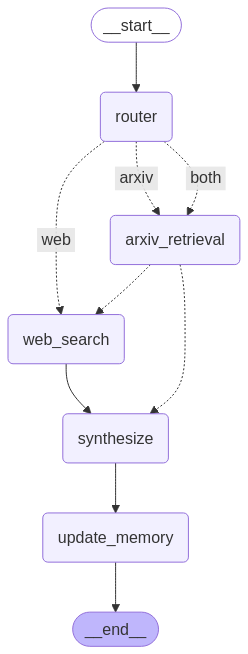

In [13]:
# Optional: Display the new graph structure
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

## 9. Testing the System

Let's **test our system** with different types of questions:

- **Questions answerable** from ArXiv papers
- **Questions requiring** web search
- **Follow-up questions** to test memory


In [21]:
memory = ConversationBufferMemory(return_messages=False, output_key="answer", input_key="question")

# *** CLEAR MEMORY HERE (Optional, but ensures clean start) ***
print("Clearing memory before initial state creation.")
memory.clear()

initial_state = {
    "question": None,
    "routing_decision": None, # Initialize new state field
    "arxiv_results": None,
    "web_results": None,
    "direct_answer": None,
    "answer": "",
    "conversation_history": memory.load_memory_variables({}).get("history", ""),
    "memory": memory,
    "next_node": None # Initialize helper key
}
print("Initial State Prepared (Memory Cleared):")
print(initial_state)

Clearing memory before initial state creation.
Initial State Prepared (Memory Cleared):
{'question': None, 'routing_decision': None, 'arxiv_results': None, 'web_results': None, 'direct_answer': None, 'answer': '', 'conversation_history': '', 'memory': ConversationBufferMemory(chat_memory=InMemoryChatMessageHistory(messages=[]), output_key='answer', input_key='question'), 'next_node': None}


In [22]:
def ask(app, question: str, state: AgentState):
    """
    Ask a question to the agentic RAG system and print result details.

    Args:
        app: The compiled LangGraph application.
        question: User's question.
        state: The current AgentState dictionary (will be updated).

    Returns:
        The final AgentState dictionary after workflow invocation.
    """
    # Invoke the workflow
    state['question'] = question
    
    # Ensure conversation history is loaded for this turn
    state['conversation_history'] = state['memory'].load_memory_variables({}).get("history", "")

    print(f"\n{'='*30} NEW QUERY {'='*30}")
    print(boxen(f"Processing question: {question}", title=">>> Input", color="yellow", padding=1))

    # Invoke the workflow
    # Note: The 'state' dictionary is mutable and gets updated by the graph nodes
    result = app.invoke(state)
    
    found_arxiv = result.get("arxiv_results") and len(result["arxiv_results"]) > 0
    found_web = result.get("web_results") and len(result["web_results"]) > 0

    # # Print ArXiv results count if found
    # if found_arxiv:
    #     arxiv_count = len(result["arxiv_results"])
    #     print(boxen(f"Found {arxiv_count} ArXiv results", title=">>> ArXiv Results", color="magenta", padding=1))
    
    # # Print Web results count if found (independent of ArXiv)
    # if found_web:
    #     web_count = len(result["web_results"])
    #     print(boxen(f"Found {web_count} Web results", title=">>> Web Results", color="cyan", padding=1))
    
    # Print "No results" only if NEITHER was found
    if not found_arxiv and not found_web:
        print(boxen("No relevant information found from any source", title=">>> Results", color="red", padding=1))

    # Print the final synthesized answer
    # The answer content itself should indicate which sources were used based on the synthesize_node logic
    print(boxen(result["answer"], title=">>> Final Answer", color="green", padding=(1, 2)))
    print(f"{'='*30} QUERY END {'='*30}\n")

    # Return the final state which includes the updated memory, answer, etc.
    return result

In [25]:
# Test with a question about quantum computing (should use ArXiv)
# updated_state = ask(app, "Explain quantum computing", initial_state)

# Test with a question about drawing (should use web)
# updated_state = ask(app, "Explain how to draw a cat", initial_state)

# Test with a question about latest techniques (should use both ArXiv and web)
updated_state = ask(app, "Explain the most recent techniques used in software refactoring. Support it with the online examples", initial_state)


============================== NEW QUERY ==============================


╭─ >>> Input ─────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│   Processing question: Explain the most recent techniques used in software refactoring. Support it with the     │
│   online examples                                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯



╭─ >>> Router Node ───────────╮                                                                                    
│                             │                                                                                    
│  Router raw decision: both  │                                                                                    
│                             │                                                                                    
╰─────────────────────────────╯                                                                                    



╭─ >>> ArXivProcessor ────────────────────────────╮                                                                
│                                                 │                                                                
│   Found 5 relevant chunks above threshold 0.5   │                                                                
│                                                 │                                                                
╰─────────────────────────────────────────────────╯                                                                



╭─ >>> ArXiv Retrieval Node ───────╮                                                                               
│                                  │                                                                               
│  Found 5 relevant ArXiv chunks.  │                                                                               
│                                  │                                                                               
╰──────────────────────────────────╯                                                                               



╭─ >>> Routing ─────────────────────────────────────────────────╮                                                  
│                                                               │                                                  
│  Routing decision was 'both', proceeding to Web Search next.  │                                                  
│                                                               │                                                  
╰───────────────────────────────────────────────────────────────╯                                                  



╭─ >>> Web Search Node ───────────────────────╮                                                                    
│                                             │                                                                    
│  Found 5 web results. Direct answer found.  │                                                                    
│                                             │                                                                    
╰─────────────────────────────────────────────╯                                                                    



╭─ >>> Synthesize Answer Node ───────────────────╮                                                                 
│                                                │                                                                 
│  Synthesizing from Both ArXiv and Web Results  │                                                                 
│                                                │                                                                 
╰────────────────────────────────────────────────╯                                                                 



╭─ >>> Final Answer ──────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│  ## Context                                                                                                     │
│  **Question:** Explain the most recent techniques used in software refactoring. Support it with the online      │
│  examples                                                                                                       │
│  **Source(s) Used:** Combined ArXiv and Web                                                                     │
│                                                                                                                 │
│  ## Response                                                                                                    │
│  ## Recent Techniques in Software Refactoring                         

## 🎓 Conclusion

The Agentic RAG System with ArXiv + Web Fallback represents a powerful approach to information retrieval and synthesis, combining the best of both academic and real-time knowledge sources. By intelligently routing queries and maintaining conversation context, it provides:

- **Comprehensive Answers**: Leveraging both academic papers and current web information
- **Proper Attribution**: Ensuring all sources are properly cited
- **Contextual Understanding**: Maintaining conversation history for coherent interactions
- **Flexible Knowledge Access**: Adapting to different types of queries and information needs

This system is particularly valuable for:
- Researchers seeking both theoretical foundations and practical applications
- Developers looking for up-to-date technical information
- Students and professionals needing comprehensive, well-sourced answers
- Anyone requiring a balance between academic rigor and current information

The modular architecture and use of LangGraph make it easy to extend and adapt the system for specific use cases or additional knowledge sources.